In [49]:
## Rvec & Tvec 구하기 (카메라 좌표계 변환)
import os
import json
import cv2
import numpy as np

joint_path = '/home/najo/NAS/DIP/datasets/FR5_model/joint'
joint_filename = [f for f in os.listdir(joint_path) if f.endswith('.json')]

with open(os.path.join(joint_path, joint_filename[0]), 'r') as file:
    data = json.load(file)

# 3D 물체의 좌표 (월드 좌표계, mm 단위)
world_points = np.array(data, dtype=np.float32) * 1000

# 2D Image Points (예: 카메라 이미지에서의 픽셀 좌표)
image_points = np.array([[700, 435], [729, 364], [832, 197], [771, 179], [799, 111], [801, 68]], dtype=np.float32)

# Camera Intrinsics (내부 파라미터 행렬)
camera_matrix = np.array([[533, 0, 653],
                           [0, 533, 377],
                           [0, 0, 1]], dtype=np.float32)

# Distortion Coefficients (왜곡 계수, 예: 없는 경우 0으로 설정)
dist_coeffs = np.zeros(5)  # [k1, k2, p1, p2, k3]

# Solve PnP to find Rvec and Tvec
success, rvec, tvec = cv2.solvePnP(world_points, image_points, camera_matrix, dist_coeffs)

if success:
    print("Rotation Vector (Rvec):", rvec)
    print("Translation Vector (Tvec):", tvec)

    # Rvec을 Rotation Matrix로 변환
    rotation_matrix, _ = cv2.Rodrigues(rvec)
    print("Rotation Matrix (R):", rotation_matrix)
else:
    print("PnP 솔루션을 찾을 수 없습니다.")


Rotation Vector (Rvec): [[ 1.52472733]
 [-2.58427355]
 [-0.50111829]]
Translation Vector (Tvec): [[ -22.78304435]
 [-108.83877894]
 [-549.03054116]]
Rotation Matrix (R): [[-0.49387714 -0.83308856 -0.249096  ]
 [-0.86581234  0.44468607  0.22939768]
 [-0.08033906  0.32896466 -0.94091864]]


In [21]:
import cv2
import numpy as np

def world_to_camera_using_rvec_tvec(world_points, rvec, tvec):
    # Convert Rvec to Rotation Matrix
    rotation_matrix, _ = cv2.Rodrigues(rvec)
    
    # Convert world points to camera points
    world_points = np.array(world_points, dtype=np.float32)  # Ensure it's a numpy array
    camera_points = np.dot(rotation_matrix, world_points.T).T + tvec.T
    
    return camera_points

# Example usage
if __name__ == "__main__":
    # Example world points (3D)
    world_points = np.array(data, dtype=np.float32) * 1000

    # Transform world points to camera coordinates
    camera_points = world_to_camera_using_rvec_tvec(world_points, rvec, tvec)
    print("Camera Coordinates:\n", camera_points)


Camera Coordinates:
 [[  -76.16340047   -94.64693688  -674.06374668]
 [ -183.1698104    -27.84145463 -1079.91060332]
 [ -302.92847248   270.93022375  -850.96006231]
 [ -214.06188476   318.50523788  -866.55959834]
 [ -255.79830993   406.45170454  -836.10488372]
 [ -228.68559379   386.69646089  -741.89962304]]


In [22]:
import numpy as np

def camera_to_normalized_space(camera_points, camera_matrix):
    # Extract intrinsic parameters
    fx = camera_matrix[0, 0]
    fy = camera_matrix[1, 1]
    cx = camera_matrix[0, 2]
    cy = camera_matrix[1, 2]

    # Normalize points
    camera_points = np.array(camera_points, dtype=np.float32)
    normalized_points = []
    
    for point in camera_points:
        x_camera, y_camera, z_camera = point
        x_normalized = (x_camera / z_camera - cx) / fx
        y_normalized = (y_camera / z_camera - cy) / fy
        normalized_points.append([x_normalized, y_normalized])
    
    return np.array(normalized_points)

# Example usage
if __name__ == "__main__":
    # Example camera points (3D, in camera coordinates)
    camera_points = np.array([[ 146.4819039,   -83.69368496, 1070.31110705],
    [ 118.86879303, -20.56099649,  650.93443265],
    [ 173.61407243, 320.72465674,  842.1203643 ],
    [ 274.6158032, 309.21881817,  833.73800391],
    [ 287.50952055,  408.61454087,  852.66529075],
    [ 293.42452521,  389.20117882, 950.58430964]], dtype=np.float32)

    # Camera intrinsic matrix
    camera_matrix = np.array([[528, 0, 640],
                           [0, 528, 360],
                           [0, 0, 1]], dtype=np.float32)
    # Transform to normalized space
    normalized_points = camera_to_normalized_space(camera_points, camera_matrix)
    print("Normalized Space Coordinates:\n", normalized_points)


Normalized Space Coordinates:
 [[-1.2118621  -0.68196625]
 [-1.2117753  -0.68187803]
 [-1.2117307  -0.68109685]
 [-1.2114973  -0.68111575]
 [-1.2114825  -0.6809106 ]
 [-1.2115366  -0.68104273]]


In [23]:
import numpy as np

def normalized_to_pixel(normalized_points, camera_matrix):
    # Extract intrinsic parameters
    fx = camera_matrix[0, 0]
    fy = camera_matrix[1, 1]
    cx = camera_matrix[0, 2]
    cy = camera_matrix[1, 2]

    # Convert normalized coordinates to pixel coordinates
    pixel_points = []
    for point in normalized_points:
        x_norm, y_norm = point
        x_pixel = x_norm * fx + cx
        y_pixel = y_norm * fy + cy
        pixel_points.append([x_pixel, y_pixel])

    return np.array(pixel_points)

# Example usage
if __name__ == "__main__":
    # Normalized coordinates (x_norm, y_norm)
    normalized_points = np.array([[-1.2118621,  -0.68196625],
    [-1.2117753,  -0.68187803],
    [-1.2117307,  -0.68109685],
    [-1.2114973,  -0.68111575],
    [-1.2114825,  -0.6809106 ],
    [-1.2115366,  -0.68104273]])

    # Camera intrinsic matrix
    camera_matrix = np.array([[528, 0, 640],
                           [0, 528, 360],
                           [0, 0, 1]], dtype=np.float32)

    # Convert to pixel coordinates
    pixel_points = normalized_to_pixel(normalized_points, camera_matrix)
    print("Pixel Coordinates:\n", pixel_points)


Pixel Coordinates:
 [[ 0.1368112  -0.07818   ]
 [ 0.1826416  -0.03159984]
 [ 0.2061904   0.3808632 ]
 [ 0.3294256   0.370884  ]
 [ 0.33724     0.4792032 ]
 [ 0.3086752   0.40943856]]


In [180]:
import os
import json
import cv2
import numpy as np

joint_path = '/home/najo/NAS/DIP/datasets/FR5_model/joint'
joint_filename = [f for f in os.listdir(joint_path) if f.endswith('.json')]

with open(os.path.join(joint_path, joint_filename[0]), 'r') as file:
    data = json.load(file)
    
with open(os.path.join(joint_path, joint_filename[813]), 'r') as file:
    data2 = json.load(file)

# 입력 데이터
# world_coordinates = np.array(data, dtype=np.float32) * 1000
world_coordinates = np.array(data2, dtype=np.float32) * 1000
# world_coordinates = np.concatenate((world_coordinates1, world_coordinates2), axis=0)

pixel_coordinates = np.array([
    # [700, 435],
    # [729, 364],
    # [832, 197],
    # [771, 179],
    # [799, 111],
    # [801, 68],
    
    [700, 435],
    [666, 319],
    [628, 143],
    [586, 156],
    [570, 107],
    [572, 120]
], dtype=np.float32)

# camera_matrix = np.array([[533.255, 0, 653.255],
#                            [0, 533.445, 377.8895],
#                            [0, 0, 1]], dtype=np.float32)

camera_matrix = np.array([[528, 0, 640],
                        [0, 528, 360],
                        [0, 0, 1]], dtype=np.float32)

# dist_coeffs = np.array([-1.2344, 2.4083, 0.0006, 0.0002, 0.1109, -1.1462, 2.2641, 0.2641], dtype=np.float32)  # 왜곡 계수 (왜곡 없다고 가정)
dist_coeffs =np.zeros(5)
# Step 1: SolvePnP를 통해 Rvec, Tvec 계산
success, rvec, tvec = cv2.solvePnP(world_coordinates, pixel_coordinates, camera_matrix, dist_coeffs)

# rvec = np.array([[119.83], [-0.2481], [0.5898]])
# tvec = np.array([[0.0006], [0.0], [0.0018]])

if not success:
    print("PnP 계산 실패")
else:
    print("Rotation Vector (Rvec):\n", rvec)
    print("Translation Vector (Tvec):\n", tvec)

    # Step 2: World -> Camera 좌표 변환
    rotation_matrix, _ = cv2.Rodrigues(rvec)  # Rvec을 Rotation Matrix로 변환
    camera_coordinates = []
    for world_point in world_coordinates:
        camera_point = np.dot(rotation_matrix, world_point) + tvec.flatten()
        camera_coordinates.append(camera_point)
    camera_coordinates = np.array(camera_coordinates)
    print("Camera Coordinates:\n", camera_coordinates)

    # Step 3: Camera -> Normalized Space 변환
    normalized_coordinates = []
    for camera_point in camera_coordinates: 
        x_camera, y_camera, z_camera = camera_point
        x_normalized = x_camera / z_camera
        y_normalized = y_camera / z_camera
        normalized_coordinates.append([x_normalized, y_normalized])
    normalized_coordinates = np.array(normalized_coordinates)
    print("Normalized Space Coordinates:\n", normalized_coordinates)

    # Step 4: Normalized Space -> Pixel 좌표 변환
    pixel_estimated_coordinates = []
    for norm_point in normalized_coordinates:
        x_norm, y_norm = norm_point
        x_pixel = x_norm * camera_matrix[0, 0] + camera_matrix[0, 2]
        y_pixel = y_norm * camera_matrix[1, 1] + camera_matrix[1, 2]
        pixel_estimated_coordinates.append([x_pixel, y_pixel])
    pixel_estimated_coordinates = np.array(pixel_estimated_coordinates)
    print("Estimated Pixel Coordinates:\n", pixel_estimated_coordinates)


Rotation Vector (Rvec):
 [[-0.7491676 ]
 [ 0.78741325]
 [ 3.59471026]]
Translation Vector (Tvec):
 [[  -58.94510717]
 [ -239.05210009]
 [-1588.63411225]]
Camera Coordinates:
 [[ -130.0535034   -201.07401621 -1459.77270945]
 [ -100.1299038    112.02336643 -1173.94128001]
 [  127.56467402   431.84374444 -1130.4086703 ]
 [   60.33596908   486.96790525 -1183.75307943]
 [  120.37484384   568.92997021 -1174.72204688]
 [  167.18446064   543.98173464 -1259.49496415]]
Normalized Space Coordinates:
 [[ 0.08909161  0.13774337]
 [ 0.08529379 -0.09542502]
 [-0.11284828 -0.38202444]
 [-0.05097006 -0.41137625]
 [-0.10247092 -0.48431029]
 [-0.13273928 -0.43190465]]
Estimated Pixel Coordinates:
 [[687.04037098 432.72850072]
 [685.03512238 309.6155911 ]
 [580.41610822 158.29109325]
 [613.08780672 142.79333888]
 [585.89535651 104.28416912]
 [569.91365767 131.95434355]]


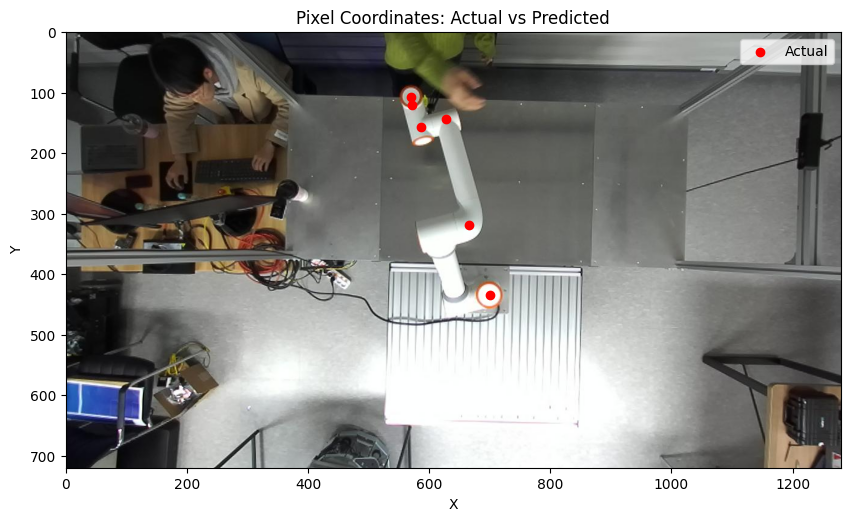

In [186]:
import matplotlib.pyplot as plt

# 실제 좌표와 예측 좌표 비교
image = cv2.imread("/home/najo/NAS/DIP/datasets/FR5_model/image/image814.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

actual_pixel_coords = pixel_coordinates
predicted_pixel_coords = pixel_estimated_coordinates
plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("on")
plt.scatter(actual_pixel_coords[:, 0], actual_pixel_coords[:, 1], color='red', label='Actual')
# plt.scatter(predicted_pixel_coords[:, 0], predicted_pixel_coords[:, 1], color='blue', label='Predicted')
plt.legend()
plt.title("Pixel Coordinates: Actual vs Predicted")
plt.xlabel("X")
plt.ylabel("Y")

plt.show()


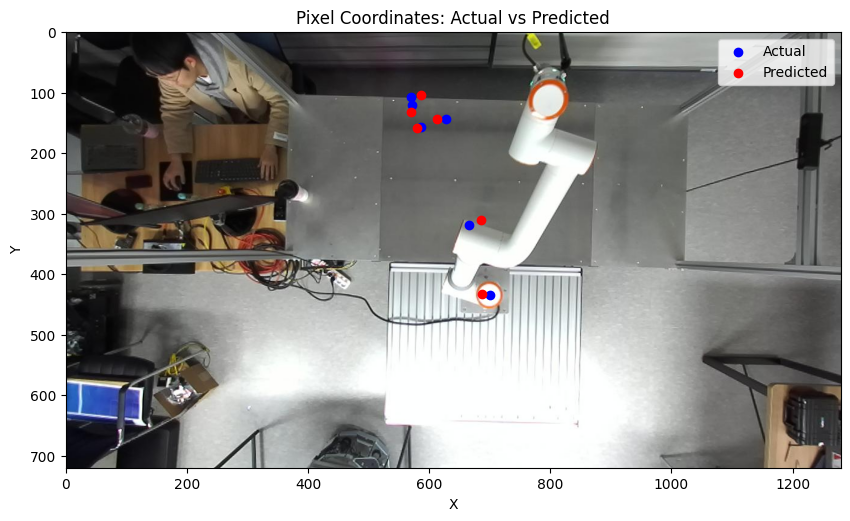

In [185]:
import matplotlib.pyplot as plt

# 실제 좌표와 예측 좌표 비교
image = cv2.imread("/home/najo/NAS/DIP/datasets/FR5_model/image/image0.jpg")
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for Matplotlib

plt.figure(figsize=(10, 6))
plt.imshow(image)
plt.axis("on")

plt.scatter(actual_pixel_coords[:, 0], actual_pixel_coords[:, 1], color='blue', label='Actual')
plt.scatter(predicted_pixel_coords[:, 0], predicted_pixel_coords[:, 1], color='red', label='Predicted')
plt.legend()
plt.title("Pixel Coordinates: Actual vs Predicted")
plt.xlabel("X")
plt.ylabel("Y")

plt.show()
